# Parametric SHRED Tutorial

### Fetch Kuramoto Sivashinsky Dataset

In [49]:
import numpy as np
import urllib.request
# URL of the NPZ file
url = 'https://zenodo.org/records/14524524/files/KuramotoSivashinsky_data.npz?download=1'
# Local filename to save the downloaded file
filename = 'KuramotoSivashinsky_data.npz'
# Download the file from the URL
urllib.request.urlretrieve(url, filename)
# Load the data from the NPZ file
dataset = np.load(filename)

### Getting Started

In [50]:
%load_ext autoreload
%autoreload 2
from pyshred import SHRED, ParametricSHREDDataManager, evaluate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Sensor & Data Processing

In [51]:
import os

# Initialize ParametricSHREDDataManager
manager = ParametricSHREDDataManager(
    lags = 20,
    train_size = 0.8,
    val_size = 0.1,
    test_size = 0.1,
    compression = 50,
    )

# dataset = np.load('kuramoto_sivashinsky\KuramotoSivashinsky_data.npz')
data = dataset['u'] # shape (500, 201, 100)
mu = dataset['mu'] # shape (500, 201, 2)

manager.add(
    data=data,
    # random_sensors=3,
    stationary_sensors=[(15,),(30,),(45,)],
    params=mu,
    id = 'DS'
)

In [52]:
manager.sensor_measurements

,trajectory,DS-0,DS-1,DS-2
0,0,0.154032,-1.140074,-0.006130
1,0,0.332515,-1.079287,-0.023609
2,0,0.361393,-1.070717,0.002758
3,0,0.404951,-1.049306,0.015024
4,0,0.485893,-1.031259,0.017951
...,...,...,...,...
100495,499,0.261712,-1.793277,-0.135204
100496,499,-0.622521,-1.301706,0.021596
100497,499,-1.591052,-0.838068,0.158474
100498,499,-2.129965,-0.466887,0.281114


In [53]:
manager.sensor_summary

,field id,sensor id,sensor type,location/trajectory
0,DS,DS-0,stationary (user selected),"(15,)"
1,DS,DS-1,stationary (user selected),"(30,)"
2,DS,DS-2,stationary (user selected),"(45,)"


In [54]:
manager.params

,trajectory,DS param 0,DS param 1
0,0,1.423285,1.568899
1,0,1.423285,1.568899
2,0,1.423285,1.568899
3,0,1.423285,1.568899
4,0,1.423285,1.568899
...,...,...,...
100495,499,1.160304,1.782302
100496,499,1.160304,1.782302
100497,499,1.160304,1.782302
100498,499,1.160304,1.782302


### Dataset Splitting

In [55]:
manager.params

,trajectory,DS param 0,DS param 1
0,0,1.423285,1.568899
1,0,1.423285,1.568899
2,0,1.423285,1.568899
3,0,1.423285,1.568899
4,0,1.423285,1.568899
...,...,...,...
100495,499,1.160304,1.782302
100496,499,1.160304,1.782302
100497,499,1.160304,1.782302
100498,499,1.160304,1.782302


In [56]:
# Get train/val/test datasets
train_set, val_set, test_set = manager.preprocess()

# print ('Reconstructor Data Shape')
print('train X:', train_set.reconstructor_dataset.X.shape)
print('train Y:', train_set.reconstructor_dataset.Y.shape)
print('val X:', val_set.reconstructor_dataset.X.shape)
print('val Y:', val_set.reconstructor_dataset.Y.shape)
print('test X:', test_set.reconstructor_dataset.X.shape)
print('test Y:', test_set.reconstructor_dataset.Y.shape)

train X: torch.Size([80400, 21, 5])
train Y: torch.Size([80400, 50])
val X: torch.Size([10050, 21, 5])
val Y: torch.Size([10050, 50])
test X: torch.Size([10050, 21, 5])
test Y: torch.Size([10050, 50])


### Model Training|

In [57]:
# initialize SHRED
shred = SHRED(sequence='LSTM', decoder='SDN')
# fit SHRED
val_errors = shred.fit(train_set, val_set, num_epochs=2, verbose=True)


Fitting Reconstructor...


Epoch 2/2: 100%|██████████| 1257/1257 [00:14<00:00, 87.85batch/s, loss=0.00321, L2=0.124, val_loss=0.00262, val_L2=0.112]


### Model Evaluation

In [58]:
evaluate(model = shred, dataset=test_set)

,L2 Error
reconstruction,0.116954


In [59]:
evaluate(model = shred, dataset=test_set, data_manager=manager)

,DS
reconstruction,0.397777


In [60]:
### Helper functions for plotting SST Data
import matplotlib.pyplot as plt
import numpy as np

def plot_frame_comparison(data, data_truth, index, cmap="RdBu_r"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # Find global min and max for consistent color mapping
    vmin = min(data[index].min(), data_truth[index].min())
    vmax = max(data[index].max(), data_truth[index].max())
    # Plot Model Output
    im1 = axes[0].imshow(data[index], cmap=cmap, aspect="auto", vmin=vmin, vmax=vmax)
    axes[0].set_title("Model Output")
    axes[0].grid(False)
    # Plot Ground Truth
    im2 = axes[1].imshow(data_truth[index], cmap=cmap, aspect="auto", vmin=vmin, vmax=vmax)
    axes[1].set_title("Ground Truth")
    axes[1].grid(False)
    # Add a single shared colorbar
    cbar = fig.colorbar(im1, ax=axes, orientation="vertical", fraction=0.02, pad=0.04)
    # plt.tight_layout()
    plt.show()

def plot_frame_difference(data, data_truth, index, cmap="RdBu_r"):
    # Compute absolute error (difference map)
    error_map = np.abs(data[index] - data_truth[index])
    # Plot the difference map
    plt.figure(figsize=(10, 6))
    im = plt.imshow(error_map, cmap=cmap, aspect="auto")
    plt.colorbar(im)
    plt.title(f"Absolute Error")
    plt.grid(False)
    plt.show()

def plot_single_frame(data, index, cmap="RdBu_r"):
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(data[index], cmap=cmap, aspect="auto")
    # Add colorbar
    fig.colorbar(im, ax=ax)
    # Remove grid
    ax.grid(False)
    plt.show()

In [61]:
### Reconstruct - Test Dataset
reconstruction = shred.reconstruct(test_set.reconstructor_dataset.X)
# Post-processing
recon_dict_out = manager.postprocess(reconstruction)
recon_dict_truth = manager.postprocess(test_set.reconstructor_dataset.Y.cpu().numpy())

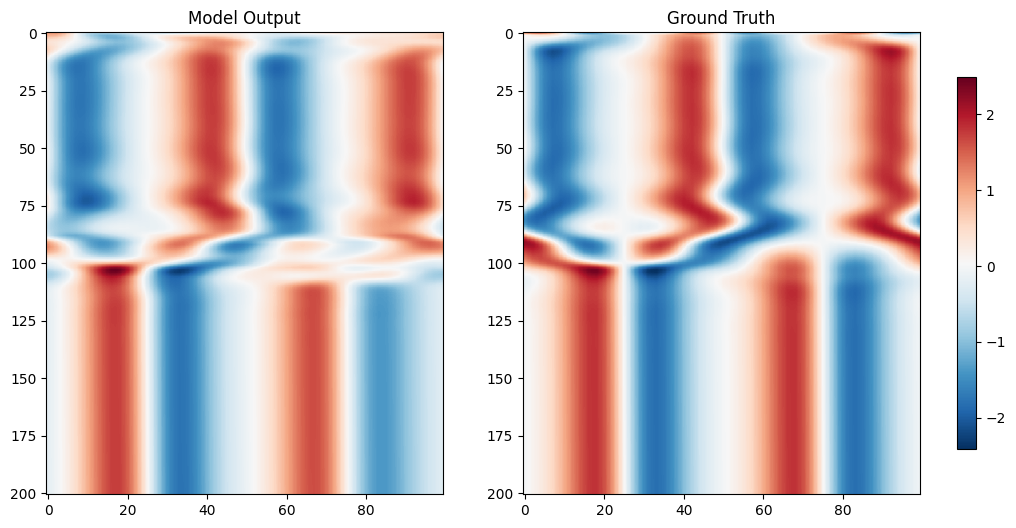

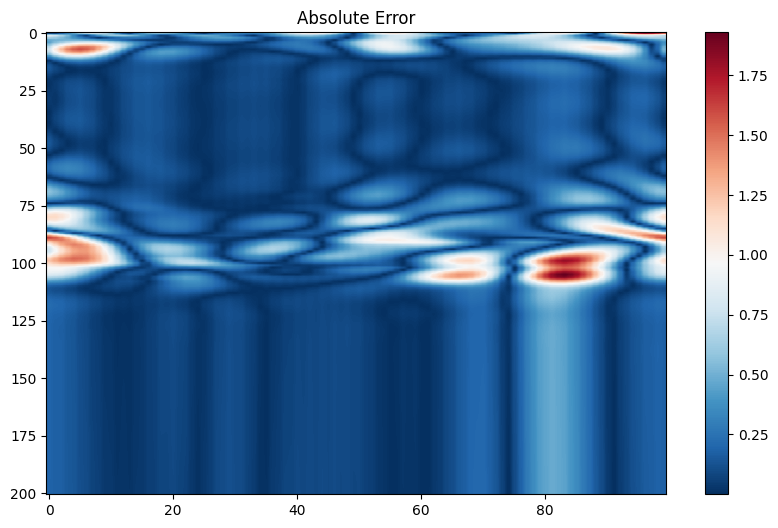

In [62]:
# Sample plot of Ground Truth vs. Reconstruction
index = 100
plot_frame_comparison(recon_dict_out["DS"], recon_dict_truth["DS"], index=40)
plot_frame_difference(recon_dict_out["DS"], recon_dict_truth["DS"], index=40)

In [63]:
fake_new_sensor_data = dataset['u'][0:10, :, [15, 30, 45]]
fake_new_mu = mu[0:10,:,:]
fake_new_X = manager.generate_X(fake_new_sensor_data, params = fake_new_mu)

In [64]:
reconstruction = shred.reconstruct(fake_new_X)